# Part    1    ‑    Exploratory    data    analysis  
The logins.json file contains (simulated) timestamps of user logins in a particular geographic location. Aggregate these login counts based on 15-minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them.

In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import calendar
import seaborn as sns
from datetime import datetime, timedelta
%matplotlib inline

In [2]:
df_logins = pd.read_json('logins.json')

In [3]:
df_logins.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [4]:
df_logins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
login_time    93142 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [5]:
df_logins.set_index('login_time', inplace=True)
df_logins['count'] = 1

In [6]:
resampled = df_logins.resample('15T', label='right').sum()

In [7]:
print(resampled.head())
print(resampled.tail())

                     count
login_time                
1970-01-01 20:15:00      2
1970-01-01 20:30:00      6
1970-01-01 20:45:00      9
1970-01-01 21:00:00      7
1970-01-01 21:15:00      1
                     count
login_time                
1970-04-13 18:00:00      5
1970-04-13 18:15:00      5
1970-04-13 18:30:00      2
1970-04-13 18:45:00      7
1970-04-13 19:00:00      6


In [8]:
resampled.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9788 entries, 1970-01-01 20:15:00 to 1970-04-13 19:00:00
Freq: 15T
Data columns (total 1 columns):
count    9788 non-null int64
dtypes: int64(1)
memory usage: 152.9 KB


We see that there are not currently any null values, and our time range is from 1/1/1970 through 4/13/1970. This means we don't need to correct any N/A values. Next we'll take a look at some statistical data for the number of logins to see what may be occuring.

In [9]:
resampled.describe()

,count
count,9788.000000
mean,9.515938
std,8.328818
min,0.000000
25%,3.000000
50%,7.000000
75%,13.000000
max,73.000000


We should note that the average logins within a 15 minute period is 9.5, and the max is 73. That seems pretty high. We're going to look more into the time date time stamp to better see what's going on.

In [10]:
resampled['time'] = pd.to_datetime(resampled.index)
resampled['month'] = resampled.time.dt.month
resampled['day'] = resampled.time.dt.day
resampled['hour'] = resampled.time.dt.hour
resampled['week'] = resampled.time.dt.week
resampled['weekday'] = resampled.time.dt.weekday
resampled['min'] = resampled.time.dt.minute

In [11]:
resampled.head()


,count,time,month,day,hour,week,weekday,min
login_time,,,,,,,,
1970-01-01 20:15:00,2,1970-01-01 20:15:00,1,1,20,1,3,15
1970-01-01 20:30:00,6,1970-01-01 20:30:00,1,1,20,1,3,30
1970-01-01 20:45:00,9,1970-01-01 20:45:00,1,1,20,1,3,45
1970-01-01 21:00:00,7,1970-01-01 21:00:00,1,1,21,1,3,0
1970-01-01 21:15:00,1,1970-01-01 21:15:00,1,1,21,1,3,15


In [12]:
def time_of_day(x):
    """Determine time of day for each row"""
    if x < 4:
        return'middle_of_night'
    elif x < 8:
        return 'early_morning'
    elif x < 12:
        return 'morning'
    elif x < 16:
        return 'afternoon'
    elif x < 20:
        return 'evening'
    else :
        return 'night'

resampled['time_of_day'] = resampled.hour.apply(time_of_day)

In [13]:
# Set the time of day as category and morph these into numeric columns for later. 
# We still need the category for now, so it won't be remooved yet
resampled.time_of_day = resampled.time_of_day.astype('category')
times = pd.get_dummies(resampled['time_of_day'])
resamp_df = pd.concat([resampled, times], axis=1)
num_days = len(resamp_df.groupby(['month', 'day'])) # Total number of days in dataset

## Logins grouped by time of day
The login information will be regrouped by 4 hour periods, to signify, middle of the night(12:00AM - 3:59AM), early morning (4:00AM - 7:59AM), morning (8:00AM - 11:59AM), afternoon(12:00PM - 3:59PM), evening (4:00PM - 7:59PM), and night (8:00PM - 11:59PM).
The busiest hours for our login data appears to be night and middle of the night, so 8:00PM - 4:00AM. Later we'll look a little more closely at the actual hours.

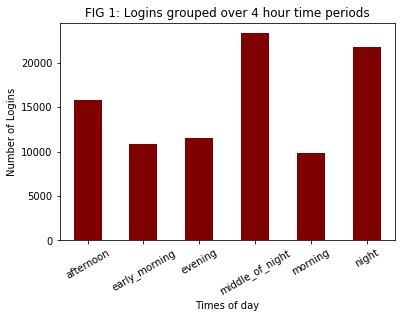

In [14]:
resamp_df['time_of_day'].cat.reorder_categories(['middle_of_night', 'early_morning', 'morning', 'afternoon', 'evening', 'night'], ordered=True)
_ = resamp_df.groupby('time_of_day')['count'].sum().plot(kind='bar', color='maroon')
plt.title("FIG 1: Logins grouped over 4 hour time periods")
plt.xlabel("Times of day")
plt.ylabel("Number of Logins")
plt.xticks(rotation=30)
plt.show()

C:\Users\sarah\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


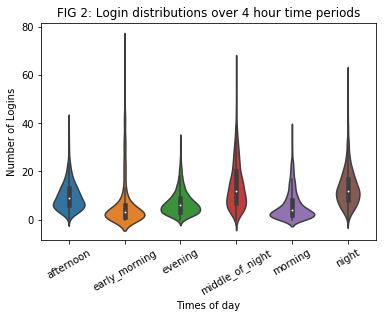

In [15]:
sns.violinplot(x='time_of_day', y='count', data=resamp_df)
plt.title("FIG 2: Login distributions over 4 hour time periods")
plt.xlabel("Times of day")
plt.ylabel("Number of Logins")
plt.xticks(rotation=30)
plt.show()

The original bar chart showed that there was a similar number of logins for early morning, evening, and morning. The violin plot helps us get a better look at the spread of the data. From it we can tell that although the averages of those three are similar, the early morning data has the biggest outlier and highest count for the data; this seems odd. The middle of the night and night time hours showed the greatest number of logins total, and wtih the violin plot we can confirm this, but also see that there are a lot of outliers that have hit much higher logins in those time frames.

## Logins by Hours

Earlier we took a look at the times of day as general groupings. Next we'll be looking at the breakout of the actual hours. 
FIG 2 more clearly shows that the busiest time for logins is 11:00PM through 4:00 AM, and there are very few logins for the morning hours. There is another spike around the typical lunch time 11:00AM-1:00PM.

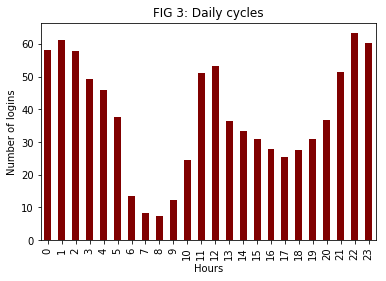

In [16]:
(resamp_df.groupby('hour')['count'].sum()/num_days).plot(kind='bar', color='maroon')
plt.title("FIG 3: Daily cycles")
plt.xlabel("Hours")
plt.ylabel("Number of logins")
plt.show()

## Logins by day

Although there isn't much of a pattern to the dates in the month and number of logins, we can see drops on the 9th, 16th, 22nd, and 30th. There are significantly less for 30th / 31st, but this could be due to only having data for January / March for those dates. 

The drop around the middle of the dates that continues to the end is due to April not having a full month of data.

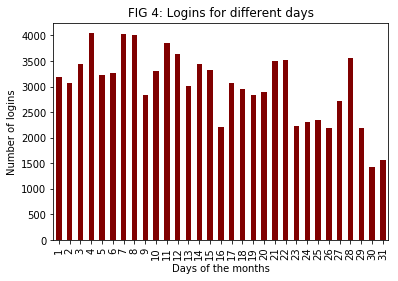

In [17]:
resamp_df.groupby('day')['count'].sum().plot(kind='bar', color='maroon')
plt.title("FIG 4: Logins for different days")
plt.xlabel("Days of the months")
plt.ylabel("Number of logins")
plt.show()

## Logins for Weekdays

FIG 5 clearly shows that the end of the week has more login traffic than the beginning of the week. 

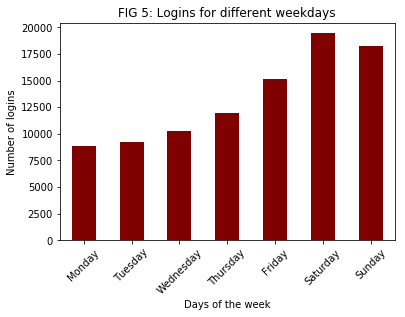

In [18]:
_ = resamp_df.groupby('weekday')['count'].sum().plot(kind='bar', color='maroon')
plt.title("FIG 5: Logins for different weekdays")
plt.xlabel("Days of the week")
plt.ylabel("Number of logins")
plt.xticks(rotation=45)
_.set_xticklabels([calendar.day_name[d] for d in range(7)])
plt.show()

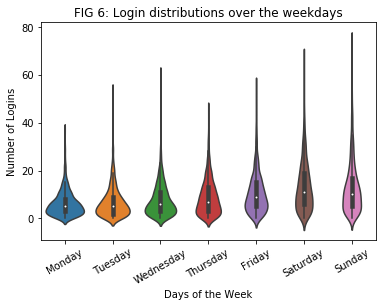

In [19]:
#swarmplot by days FIG 6
_ = sns.violinplot(x='weekday', y='count', data=resamp_df)
plt.title("FIG 6: Login distributions over the weekdays")
plt.xlabel("Days of the Week")
plt.ylabel("Number of Logins")
plt.xticks(rotation=30)
_.set_xticklabels([calendar.day_name[d] for d in range(7)])
plt.show()

The violin plot shows that there is along with an increasing average number of logins, there is also a greater spread of data later in the week. 

## Logins by month
We only have logins for the first 4 months of the year, and we only go about halfway into April, so we don't have the full month to examine. 

We can see in FIG 7 that March is the busies for the first few months of the year, and April can't be compared because the full month wasn't reported. Each month seems to be seeing an increase in the number of logins, before the data stops.

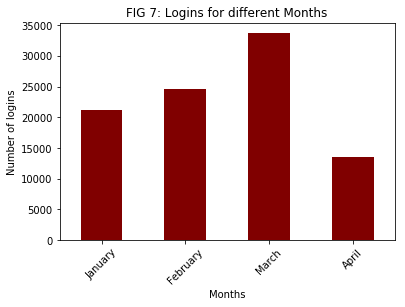

In [20]:
_ = resamp_df.groupby('month')['count'].sum().plot(kind='bar', color='maroon')
plt.title("FIG 7: Logins for different Months")
plt.xlabel("Months")
plt.ylabel("Number of logins")
plt.xticks(rotation=45)
_.set_xticklabels([calendar.month_name[d] for d in range(1,5)])
plt.show()

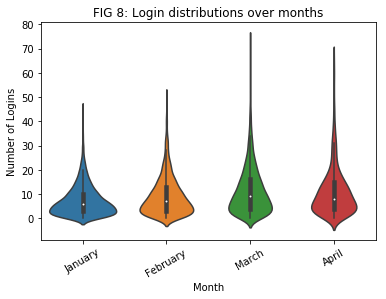

In [21]:
#violinplot FIG 8 
_ = sns.violinplot(x='month', y='count', data=resamp_df)
plt.title("FIG 8: Login distributions over months")
plt.xlabel("Month")
plt.ylabel("Number of Logins")
_.set_xticklabels([calendar.month_name[d] for d in range(1,5)])
plt.xticks(rotation=30)
plt.show()

## Logins by Weeks

Looking more into the login traffic over time for the year, the number of logins by the week of the year shows an upward trend for logins each week. 

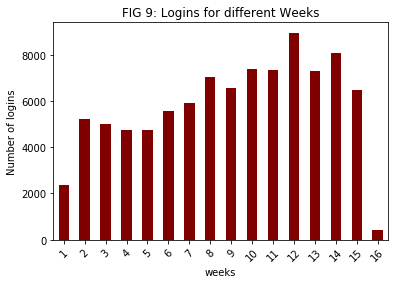

In [22]:
resamp_df.groupby('week')['count'].sum().plot(kind='bar', color='maroon')
plt.title("FIG 9: Logins for different Weeks")
plt.xlabel("weeks")
plt.ylabel("Number of logins")
plt.xticks(rotation=45)
plt.show()

## Logins by 15 Minute intervals
FIG 10 shows that the different minutes of the hours are pretty easily distributed for logins.

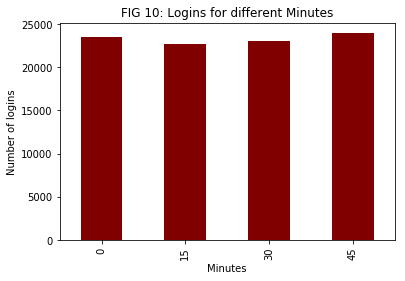

In [23]:
resamp_df.groupby('min')['count'].sum().plot(kind='bar', color='maroon')
plt.title("FIG 10: Logins for different Minutes")
plt.xlabel("Minutes")
plt.ylabel("Number of logins")
plt.show()

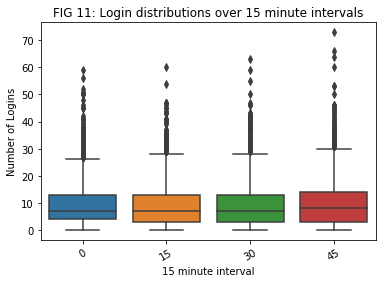

In [24]:
sns.boxplot(x='min', y='count', data=resamp_df)
plt.title("FIG 11: Login distributions over 15 minute intervals")
plt.xlabel("15 minute interval")
plt.ylabel("Number of Logins")
plt.xticks(rotation=30)
plt.show()

In FIG 10 we could see that travel seems pretty balanced through the minutes of the hour, and by constructing the boxplot in FIG 11, we can better understand the data. The spreads of the four intervals is still pretty even, but we can see a peak and some more extreme outliers during the last 15 minutes of the hour.

## Summary of results:
    a) There is an increase in the number of logins each month, peaking in March due to missing data for April
    b) Weekends are the most active times for logins
    c) 10:00PM through 4:00AM has the highest traffic for logins
    d) There is a significant drop in the number of logins between the morning hours of 6:00AM and 11:00AM
    e) Lunch time sparks another increase in logins that slowly drops for the evening hours. 
    f) The 12th week of the year had the most logins, with a slight drop for the following week. 
       The 12th week is the last week of March

# Part 2 - Experiment and metrics design
The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.

However, a toll bridge, with a two-way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.


## 1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?



#  
    To measure the success of the experiment, I would track the toll driver patterns on both sides and compare the amounts being collected by the tolls both directions to the amounts being reimbursed for tolls to driver partners. The higher percentage of the reimbursment of the total cost would mean the more driver partners that are available in both cities, meaning the experiment is more successful.

## 2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:
    a) how you will implement the experiment
        To implement this experiment by collecting data for the amount reimbursed in toll costs, and include the driver
        patterns, the direction they were going, date, time, and toll cost charged. Next I will analyze the data to find
        trends in regards to the amount of tolls being paid and the percentage of the total tolls being reimbursed over 
        time.
  
    b) what statistical test(s) you will conduct to verify the significance of the observation
        The statistical test that will be used is the one sample T-test.
    c) how you would interpret the results and provide recommendations to the city operations team along with any caveats.
        I will create visualizations to display more easily interpret trends for days, times, direction, and percentage. 
        I will then make recommendations from the visualizations and conclusions from the statistial analysis.

# Part 3 - Predictive modeling

Ultimate     is     interested     in     predicting     rider     retention.    To    help    explore     this    question,    we    have  provided     a     sample    dataset     of     a     cohort    of    users    who     signed    up     for    an    Ultimate    account     in 
January    2014.    The     data    was    pulled     several    months     later;    we     consider    a    user     retained     if     they  were     “active”     (i.e.     took    a     trip)     in     the     preceding    30    days.    

We     would     like     you     to    use     this    data     set     to    help    understand    what     factors    are     the    best    predictors  for     retention,    and    offer     suggestions     to     operationalize     those     insights     to    help    Ultimate.    

The    data     is     in     the    attached     file     ultimate_data_challenge.json.    See    below     for    a    detailed  description     of     the    dataset.     Please     include    any     code     you    wrote     for     the    analysis    and    delete     the  dataset    when     you    have     finished     with     the     challenge.    

1. Perform    any     cleaning,     exploratory    analysis,    and/or     visualizations     to    use     the    provided  data     for     this    analysis     (a     few     sentences/plots    describing     your    approach    will     suffice).    What  fraction     of     the    observed     users    were     retained?  
2. Build    a    predictive     model     to     help    Ultimate    determine    whether    or    not    a    user    will    be    active  in     their    6th    month     on     the     system.    Discuss    why     you     chose     your    approach,    what  alternatives     you     considered,     and    any     concerns     you    have.    How     valid     is     your    model?  Include    any     key     indicators    of     model    performance.  
3. Briefly    discuss    how     Ultimate     might     leverage     the     insights    gained     from     the    model     to  improve     its     long­  term     rider     retention     (again,    a     few     sentences    will     suffice).

In [25]:
# Read in the data
import json

file = open('ultimate_data_challenge.json', 'r')
df = pd.DataFrame(json.load(file))
file.close()

df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [26]:
df.describe()


,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct
count,50000.000000,49799.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,5.796827,4.778158,4.601559,1.074764,8.849536,2.278200,60.926084
std,5.707357,0.446652,0.617338,0.222336,19.958811,3.792684,37.081503
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,2.420000,4.700000,4.300000,1.000000,0.000000,0.000000,33.300000
50%,3.880000,5.000000,4.900000,1.000000,0.000000,1.000000,66.700000
75%,6.940000,5.000000,5.000000,1.050000,8.600000,3.000000,100.000000
max,160.960000,5.000000,5.000000,8.000000,100.000000,125.000000,100.000000


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [28]:
# Replace missing values for two average ratings column with the mean of the existing values
# drop rows that still contain a null; this is the 396 rows tha are missing a phone type
df['avg_rating_by_driver'].fillna(df['avg_rating_by_driver'].mean(), inplace=True)
df['avg_rating_of_driver'].fillna(df['avg_rating_of_driver'].mean(), inplace=True)
df.dropna(axis=0, inplace=True)

In [29]:
df.reset_index(drop=True, inplace=True)

In [30]:
# Set category columns
df['phone'] = df['phone'].astype('category')
df['city'] = df['city'].astype('category')

# Change dates to datetime 
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])
df['signup_date'] = pd.to_datetime(df['signup_date'])

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49604 entries, 0 to 49603
Data columns (total 12 columns):
avg_dist                  49604 non-null float64
avg_rating_by_driver      49604 non-null float64
avg_rating_of_driver      49604 non-null float64
avg_surge                 49604 non-null float64
city                      49604 non-null category
last_trip_date            49604 non-null datetime64[ns]
phone                     49604 non-null category
signup_date               49604 non-null datetime64[ns]
surge_pct                 49604 non-null float64
trips_in_first_30_days    49604 non-null int64
ultimate_black_user       49604 non-null bool
weekday_pct               49604 non-null float64
dtypes: bool(1), category(2), datetime64[ns](2), float64(6), int64(1)
memory usage: 3.5 MB


In [32]:
df.sort_values(by=['last_trip_date'], ascending=False, inplace=True)
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
6297,3.51,4.5,3.8,1.09,King's Landing,2014-07-01,iPhone,2014-01-04,11.8,0,False,64.7
9417,5.00,5.0,4.7,1.38,Astapor,2014-07-01,iPhone,2014-01-19,50.0,0,False,50.0
36745,5.56,4.9,3.5,1.36,Winterfell,2014-07-01,iPhone,2014-01-05,44.4,1,True,55.6
9365,1.39,5.0,5.0,1.00,Astapor,2014-07-01,Android,2014-01-27,0.0,0,False,100.0
42027,6.19,4.7,5.0,1.00,Winterfell,2014-07-01,iPhone,2014-01-28,0.0,5,False,75.0


With the most recent trip date for any account as 2014-07-01, we'll consider that to be the date of the study being conducted, so we'll take the 30 prior days to be the "retained" period. 

In [33]:
retain_date = max(df.last_trip_date) - timedelta(days=30)
print(retain_date)

2014-06-01 00:00:00


In [34]:
df['retained'] = df.last_trip_date.apply(lambda x: True if x > retain_date else False)
df.head()
df.retained.unique()

array([ True, False])

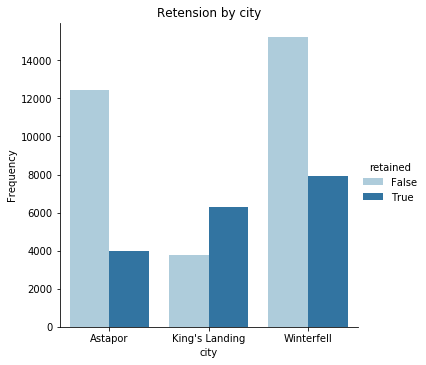

In [35]:
sns.catplot(x="city", kind="count", data=df, hue="retained", palette="Paired")
plt.ylabel("Frequency")
plt.title("Retension by city")
plt.show()

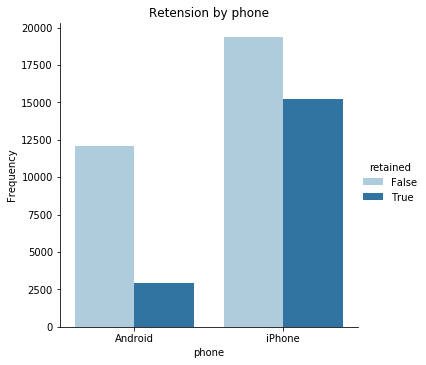

In [36]:
sns.catplot(x="phone", kind="count", data=df, hue="retained", palette="Paired")
plt.ylabel("Frequency")
plt.title("Retension by phone")
plt.show()

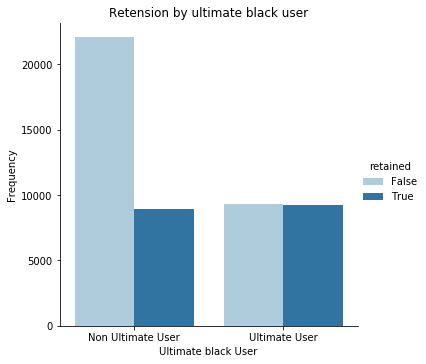

In [37]:
_ = sns.catplot(x="ultimate_black_user", kind="count", data=df, hue="retained", palette="Paired")
plt.ylabel("Frequency")
plt.title("Retension by ultimate black user")
plt.xlabel("Ultimate black User")
_.set_xticklabels(['Non Ultimate User', 'Ultimate User'])
plt.show()

In [38]:
# Retained users
percentage_retain = df['retained'].sum()/len(df)
print(percentage_retain)

0.3665027013950488


The percentage of retained users was 36.6%

## Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system


In [39]:
df.columns

Index(['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge',
       'city', 'last_trip_date', 'phone', 'signup_date', 'surge_pct',
       'trips_in_first_30_days', 'ultimate_black_user', 'weekday_pct',
       'retained'],
      dtype='object')

In [40]:
df_dropped = df.drop(['last_trip_date', 'signup_date'], axis=1)
df_ml = pd.get_dummies(df_dropped, columns = ['city', 'phone', 'ultimate_black_user'], drop_first=True)

In [41]:
X = df_ml.drop('retained', axis=1)
y = df_ml['retained']

In [42]:
#Split data set into training set and test set with the 80 to 20 ratio
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

A random forest model will be used because they have a high tendency to be more accurate than any base regression methods. It also allows to easily find the most important features in predicting. Regular linear regression was considered, but it has a tendency to overfit, and isn't as capable of handling more features. 

In [43]:
# Random Forest 
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier() # attempt with default settings to get ballpark of accuracy
rf.fit(X_train, y_train)
ypred = rf.predict(X_test)

C:\Users\sarah\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [44]:
#Calculate Accuracy Score for Random Forest with default settings
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, ypred)

print(accuracy)

0.7573833282935188


Our initial score, with default model values is 75.2. Next, we'll tune the hyperparameters to attempt to get even more accurate. 

In [45]:
# Create the hyperparameter grid
n_options = [10,20,50,100,200]
max_features = ['auto', 'sqrt', 'log2']
max_depth = np.arange(1,101,5)
param_grid = {'n_estimators': n_options, 'max_features': max_features, 'max_depth': max_depth}


# Instantiate the GridSearchCV object
rf_cv = GridSearchCV(rf, param_grid, cv=5)
# build model    
rf_cv.fit(X_train, y_train)
# predict using model
y_predict = f_cv.predict(X_test)

In [50]:
# Create the hyperparameter grid
n_options = np.arange(170,300,5)
max_features = ['auto', 'sqrt', 'log2']
max_depth = np.arange(1,31,5)
param_grid = {'n_estimators': n_options, 'max_features': max_features, 'max_depth': max_depth}


# Instantiate the GridSearchCV object
rf_cv = GridSearchCV(rf, param_grid, cv=5)
# build model    
rf_cv.fit(X_train, y_train)
# predict using model
y_predict = rf_cv.predict(X_test)

In [51]:
from sklearn import metrics

# Print the optimal parameters and best score
print("Tuned Parameter: {}".format(rf_cv.best_params_))
print("Tuned Score: {}".format(rf_cv.best_score_))
print()
# evaluate model prediction performance 
print ('Test set performance:')
print(metrics.classification_report(ypred, y_test))

Tuned Parameter: {'max_depth': 11, 'max_features': 'log2', 'n_estimators': 290}
Tuned Score: 0.790212433535771

Test set performance:
              precision    recall  f1-score   support

       False       0.84      0.79      0.82      6719
        True       0.61      0.68      0.65      3202

   micro avg       0.76      0.76      0.76      9921
   macro avg       0.73      0.74      0.73      9921
weighted avg       0.77      0.76      0.76      9921



In [53]:
#Random Forest full 

random_forest = RandomForestClassifier(n_estimators=290, max_features='log2', max_depth=11)
random_forest.fit(X_train, y_train)
train_pred = random_forest.predict(X_train)
test_pred = random_forest.predict(X_test)

In [57]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# Generate the confusion matrix
cm = confusion_matrix(y_test, test_pred)
pd.DataFrame(cm, index=range(0,2), columns=range(0,2))

,0,1
0,5448,894
1,1211,2368


In [58]:
# Classification report
print(metrics.classification_report(y_test, test_pred))
print('Test set accuracy: {:.2f}%'.format(accuracy_score(y_test, test_pred)*100))

              precision    recall  f1-score   support

       False       0.82      0.86      0.84      6342
        True       0.73      0.66      0.69      3579

   micro avg       0.79      0.79      0.79      9921
   macro avg       0.77      0.76      0.77      9921
weighted avg       0.78      0.79      0.79      9921

Test set accuracy: 78.78%


Text(0.5, 1.0, 'ROC Curve')

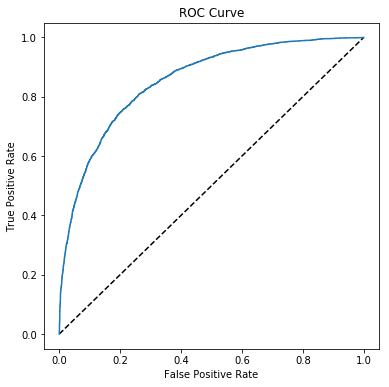

In [59]:
# Compute predicted probabilities
y_pred_prob = random_forest.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.figure(figsize=(6,6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

In [60]:
# Compute and print AUC score
print("AUC: {:.4f}".format(roc_auc_score(y_test, y_pred_prob)))

AUC: 0.8545


## Metrics of final model

* Test Set Accuracy: 78.78%
* AUC              : 0.8545

In [61]:
feat_imp = pd.DataFrame(list(zip(X.columns, random_forest.feature_importances_)), columns = ['features', 'Importance'])
feat_imp.sort_values(by='Importance', ascending=False).head(5)

,features,Importance
1,avg_rating_by_driver,0.175503
4,surge_pct,0.142333
7,city_King's Landing,0.139788
6,weekday_pct,0.112270
3,avg_surge,0.086611


# Recommendations

For our table on feature importances, we see that the most important features are 
* <b> avg_rating_by_driver </b>: The rider's average rating over all of their trips
* <b> surge_pct </b> the percent of trips taken with surge multiplier > 1
* <b> city_King's Landing </b> User's that signed up in the city of King's Landing

To improve long-term rider retention, Ultimate could do the following:
* Create incentive for user's to improve their rider score; higher rider scores influence riders to use the services more
* Slightly adjust pricing outside of surges to encourage more users to use the service during off hours
* Create a marketing event targeted to residents of King's Landing